In [1]:
%pip install pandas yfinance xgboost numpy scikit-learn matplotlib

  Using cached yfinance-0.2.65-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached xgboost-3.0.4-py3-none-macosx_10_15_x86_64.whl.metadata (2.1 kB)
  Using cached multitasking-0.0.12.tar.gz (19 kB)
  Preparing metadata (setup.py) ... done
  Using cached peewee-3.18.2.tar.gz (949 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached curl_cffi-0.13.0-cp39-abi3-macosx_10_9_x86_64.whl.metadata (13 kB)
Using cached yfinance-0.2.65-py2.py3-none-any.whl (119 kB)
Using cached xgboost-3.0.4-py3-none-macosx_10_15_x86_64.whl (2.2 MB)
Using cached curl_cffi-0.13.0-cp39-abi3-macosx_10_9_x86_64.whl (5.7 MB)
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15548 sha256=7b702ccc013c4277f860d9d40d398fc9571d32c2f20c2241a45d02fccb171fce
  Stored in directory: /Users/pankajchouhan/Library/Caches/pip/wheels/cc/bd/6f/664d62c99327abeef7d86489e6631cbf45b56fbf7ef1d6ef00
  Cr

/var/folders/b1/q44029jx1wbdmqw13ddfzf7m0000gn/T/ipykernel_26774/4071002602.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Mean Squared Error: 1027.47
R-squared Score: -0.56


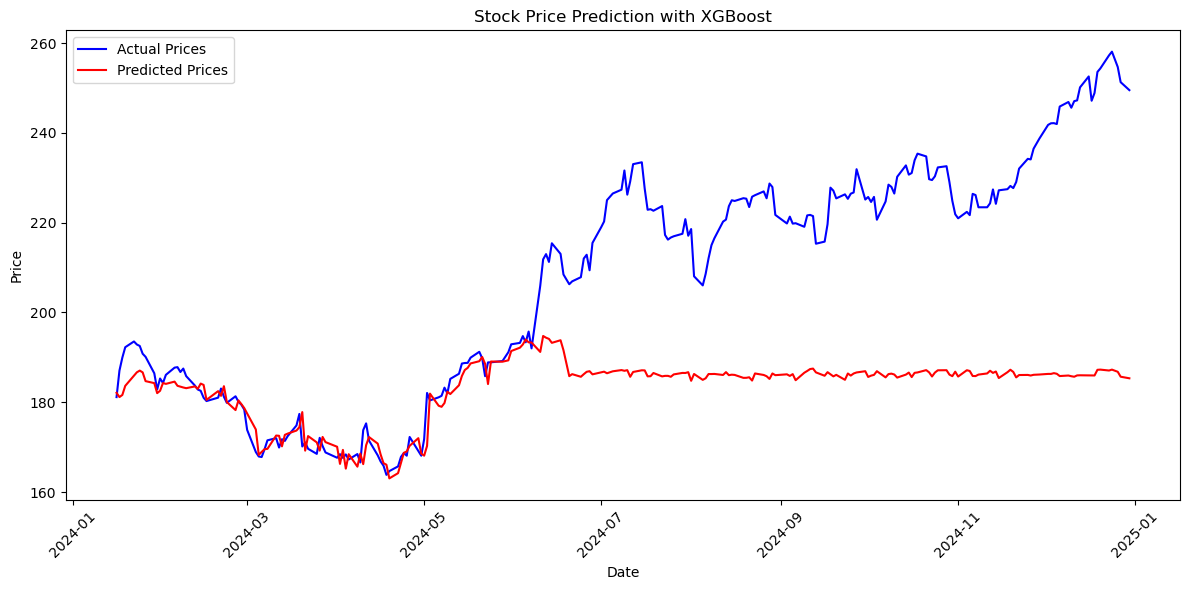


Feature Importance:
        feature  importance
0         Close    0.838182
2          MA50    0.134058
1          MA10    0.023182
5    Volatility    0.002176
3           RSI    0.001290
4  Daily_Return    0.001112


In [2]:
import pandas as pd
import yfinance as yf
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Fetch historical stock data
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# 2. Create features for the model
def create_features(df):
    # Calculate technical indicators
    df['MA10'] = df['Close'].rolling(window=10).mean()  # 10-day moving average
    df['MA50'] = df['Close'].rolling(window=50).mean()  # 50-day moving average
    df['RSI'] = compute_rsi(df['Close'], 14)  # Relative Strength Index
    df['Daily_Return'] = df['Close'].pct_change()  # Daily returns
    df['Volatility'] = df['Daily_Return'].rolling(window=10).std()  # 10-day volatility
    
    # Create target variable (next day's closing price)
    df['Target'] = df['Close'].shift(-1)
    
    # Drop rows with NaN values
    df = df.dropna()
    return df

# Helper function to compute RSI
def compute_rsi(data, periods=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# 3. Prepare data for XGBoost
def prepare_data(df, features):
    X = df[features]
    y = df['Target']
    return X, y

# 4. Train and evaluate XGBoost model
def train_xgboost(X, y):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    
    # Initialize XGBoost model
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return model, X_train, X_test, y_train, y_test, y_pred, mse, r2

# 5. Plot results
def plot_results(y_test, y_pred, dates):
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_test, label='Actual Prices', color='blue')
    plt.plot(dates, y_pred, label='Predicted Prices', color='red')
    plt.title('Stock Price Prediction with XGBoost')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Parameters
    ticker = 'AAPL'  # Apple stock
    start_date = '2020-01-01'
    end_date = '2025-01-01'
    
    # Fetch data
    df = fetch_stock_data(ticker, start_date, end_date)
    
    # Create features
    df = create_features(df)
    
    # Define features for the model
    features = ['Close', 'MA10', 'MA50', 'RSI', 'Daily_Return', 'Volatility']
    
    # Prepare data
    X, y = prepare_data(df, features)
    
    # Train and evaluate model
    model, X_train, X_test, y_train, y_test, y_pred, mse, r2 = train_xgboost(X, y)
    
    # Print evaluation metrics
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R-squared Score: {r2:.2f}")
    
    # Plot results
    test_dates = df.index[-len(y_test):]
    plot_results(y_test, y_pred, test_dates)
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    print("\nFeature Importance:")
    print(feature_importance)